Architecture was taken from https://github.com/ozanciga/gans-with-pytorch

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision
from tqdm import tqdm_notebook as tqdm
from torch.nn.utils import spectral_norm
from PIL import Image
from torch.nn import init
from time import time
CROP_DOG = True
import copy
torch.backends.cudnn.benchmark = True
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)*0.5+0.5
    plt.imshow(gen_image)
    plt.show()
    
def show_generated_batch_imgs(n):
    noise = torch.randn(n, nz, 1, 1, device=device)
    gen_images = torchvision.utils.make_grid(netG_shadow(noise).to("cpu").clone().detach()*0.5+0.5, nrow=10, padding=1)
    gen_images = gen_images.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("generated images")
    plt.imshow(gen_images)
    plt.show()

In [2]:
def update_average(model_tgt, model_src, beta):
    """
    update the model_target using exponential moving averages
    :param model_tgt: target model
    :param model_src: source model
    :param beta: value of decay beta
    :return: None (updates the target model)
    """

    # utility function for toggling the gradient requirements of the models
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    # turn off gradient calculation
    toggle_grad(model_tgt, False)
    toggle_grad(model_src, False)

    param_dict_src = dict(model_src.named_parameters())

    for p_name, p_tgt in model_tgt.named_parameters():
        p_src = param_dict_src[p_name]
        assert (p_src is not p_tgt)
        p_tgt.copy_(beta * p_tgt + (1. - beta) * p_src)

    # turn back on the gradient calculation
    toggle_grad(model_tgt, True)
    toggle_grad(model_src, True)

In [3]:
class HardMarginBCEWithLogistsLoss(nn.Module):
    def __init__(self, margin=0.7):
        super(HardMarginBCEWithLogistsLoss, self).__init__()
        self.margin = - torch.log(torch.ones(1, device=device)*margin)

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        loss = labels * torch.max(- torch.log(probs+1e-8), self.margin) - (1-labels) * torch.log(torch.clamp(1-probs+1e-8, 0, 1))
        # print(loss.size())
        return loss.sum()/logits.size(0)
class SelfAttn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(SelfAttn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8,
                                        kernel_size=1, bias=False)
        self.snconv1x1_phi = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8,
                                      kernel_size=1, bias=False)
        self.snconv1x1_g = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2,
                                    kernel_size=1, bias=False)
        self.snconv1x1_o_conv = nn.Conv2d(in_channels=in_channels//2, out_channels=in_channels,
                                         kernel_size=1, bias=False)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g - o_conv
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_o_conv(attn_g)
        # Out
        out = x + self.gamma*attn_g
        return out

# https://github.com/ajbrock/BigGAN-PyTorch/blob/master/layers.py
# Normal, non-class-conditional BN
class myBN(nn.Module):
    def __init__(self, output_size,  eps=1e-5, momentum=0.1):
        super(myBN, self).__init__()
        self.output_size= output_size
        # Prepare gain and bias layers
        self.gain = nn.Parameter(torch.ones(output_size), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(output_size), requires_grad=True)
        # epsilon to avoid dividing by 0
        self.eps = eps
        # Momentum
        self.momentum = momentum

         # Register buffers
        self.register_buffer('stored_mean', torch.zeros(output_size))
        self.register_buffer('stored_var',  torch.ones(output_size))

    def forward(self, x):
        if self.training:
            x1, x2 = x.split(x.size(0)//2, dim=0)
            x1 = F.batch_norm(x1, self.stored_mean, self.stored_var, self.gain,
                                  self.bias, self.training, self.momentum, self.eps)
            x2 = F.batch_norm(x2, self.stored_mean, self.stored_var, self.gain,
                                  self.bias, self.training, self.momentum, self.eps)
            return torch.cat([x1,x2], 0)
        else:
            return F.batch_norm(x, self.stored_mean, self.stored_var, self.gain,
                                  self.bias, self.training, self.momentum, self.eps)
        
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y


# Generator and Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3, ch=32):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, pixnorm=True):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
#             if pixnorm:
#                 block += [PixelwiseNorm()]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, ch*32, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(ch*32, ch*16, 4, 2, 1),
            *convlayer(ch*16, ch*8, 4, 2, 1),
            *convlayer(ch*8, ch*8, 3, 1, 1),
            *convlayer(ch*8, ch*4, 4, 2, 1),
            *convlayer(ch*4, ch*4, 3, 1, 1),
            *convlayer(ch*4, ch*2, 4, 2, 1),
            nn.ConvTranspose2d(ch*2, self.channels, 3, 1, 1),
            nn.Tanh()
        )
#         self.init_weights()
    
    def init_weights(self):
        self.param_count = 0
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
                init.orthogonal_(module.weight)
                self.param_count += sum([p.data.nelement() for p in module.parameters()])
        print('Param count for G''s initialized parameters: %d' % self.param_count)

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3, ch=32):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
#                 block.append(nn.BatchNorm2d(n_output))
                block.append(myBN(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
#             block.append(nn.PReLU(init=0.2))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, ch*2, 4, 2, 1),
            *convlayer(ch*2, ch*4, 4, 2, 1),
#             SelfAttn(ch*4),
            *convlayer(ch*4, ch*4, 3, 1, 1, bn=True),
            *convlayer(ch*4, ch*8, 4, 2, 1, bn=True),
            *convlayer(ch*8, ch*8, 3, 1, 1, bn=True),
            *convlayer(ch*8, ch*16, 4, 2, 1, bn=True),
#             *convlayer(ch*16, ch*16, 3, 1, 1, bn=True),
#             nn.Dropout(p=0.1),
            nn.Conv2d(ch*16, 1, 4, 1, 0, bias=True),  # FC with Conv.
#             nn.Conv2d(ch * 16, 1, 1, 1, 0, bias=True),
#             nn.AdaptiveAvgPool2d(1)
        )
#         self.init_weights()
    
    def init_weights(self):
        self.param_count = 0
        for module in self.modules():
            if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)or isinstance(module, nn.Embedding)):
                init.orthogonal_(module.weight)
                self.param_count += sum([p.data.nelement() for p in module.parameters()])
        print('Param count for D''s initialized parameters: %d' % self.param_count)
    
    def forward(self, imgs):
        logits = self.model(imgs)
#         out = torch.sigmoid(logits)
        out = logits
    
        return out.view(-1, 1)

## Parameters of GAN

In [5]:
batch_size = 32
lr = 0.0005
beta1 = 0.3
beta2 = 0.999
margin = 0.8
ema_beta = 0.9
ema_steps = [200, 300, 400]
# epochs = 200
# lr_steps = [100, 150, 180]

# G_ch=32 D_ch=32 36s
# epochs = 900
# lr_steps = [550, 700, 800]

# G_ch=32 D_ch=16 40s
# epochs = 940
# lr_steps = [550, 700, 840]

# G_ch=48 D_ch=48 52s
epochs = 620
lr_steps = [400, 520, 580]

# G_ch=64 D_ch=64
# epochs = 356
# lr_steps = [230, 270, 320]


real_label = 0.95
fake_label = 0
nz = 256
ch = 48

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader and Augmentations

In [6]:
os.listdir('../input')

['annotation', 'all-dogs']

In [7]:
import xml.etree.ElementTree as ET 
class DogDataset(torch.utils.data.Dataset):
    def __init__(self, data_root='../input/', transform=None, preload=False):
        super().__init__
        self.image_dir = os.path.join(data_root+'all-dogs/all-dogs/')
        self.transform = transform
        self.preload = preload
        self.img_paths = []
        self.annos = []
        self.imgs = []
        breeds = os.listdir(data_root + 'annotation/Annotation/') 
        for breed in breeds:
            for dog in os.listdir(os.path.join(data_root+'annotation/Annotation/'+breed)):
                if not os.path.exists(data_root+'all-dogs/all-dogs/'+dog+'.jpg'):
                    continue
                self.img_paths.append(data_root+'all-dogs/all-dogs/'+dog+'.jpg')
                tree = ET.parse(data_root+'annotation/Annotation/'+breed+'/'+dog)
                root = tree.getroot()
                objects = root.findall('object')
                bboxes = []
                imgs = []
                if preload:
                    img = Image.open(data_root+'all-dogs/all-dogs/'+dog+'.jpg')
                    if False:
                        imgs.append(img.resize((64, 64), Image.ANTIALIAS))
                for o in objects:
                    bndbox = o.find('bndbox') 
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    bboxes.append((xmin, ymin, xmax, ymax))
                    if preload:
#                         left-top and right-top
                        w = np.min((xmax - xmin, ymax - ymin))
                        img1 = img.crop((xmin, ymin, xmin+w, ymin+w))
                        img1 = img1.resize((64, 64), Image.ANTIALIAS)
                        imgs.append(img1)
                        img2 = img.crop((xmax-w, ymin, xmax, ymin+w))
                        img2 = img2.resize((64, 64), Image.ANTIALIAS)
                        imgs.append(img2)
                        if True:  # expand the bbox to a square (as far as possible). 
                            W, H = img.size
                            w, h = xmax - xmin, ymax - ymin
                            delta = abs(w-h)
                            if w>=h:
                                img3 = img.crop((xmin, max(ymin-delta//2, 0), xmax, min(ymax+delta//2, H-1)))
                            else:
                                img3 = img.crop((max(xmin-delta//2,0), ymin, min(xmax+delta//2, W-1), ymax))
                            img3 = img3.resize((64, 64), Image.ANTIALIAS)
                            imgs.append(img3)
                        if True:  # corp manner from Wu Qi
                            x=(xmax+xmin)/2
                            y=(ymax+ymin)/2
                            m2 = (ymax-ymin)*(xmax-xmin)
                            w = np.min((xmax - xmin, ymax - ymin))
                            x_top,y_top = img.size[0],img.size[1]
                            min_num = min([x_top-x,y_top-y,x,y])
                            if min([x-min_num, y-min_num,x+min_num,y+min_num])<0:
                                continue
                            x_1,y_1,x_2,y_2 = x-min_num, y-min_num,x+min_num,y+min_num
                            if x_1==0:
                                min_num2 = int(min([x_top-x_2,y_top-y_2,y_1])*0.28)
                                img4 = img.crop((x_1, y_1-min_num2,x_2+2*min_num2,y_2+min_num2))
                            elif x_2==x_top:
                                min_num2 = int(min([x_1,y_top-y_2,y_1])*0.28)
                                img4 = img.crop((x_1-2*min_num2, y_1-min_num2,x_2,y_2+min_num2))
                            elif y_1==0:
                                min_num2 = int(min([x_1,x_top-x_2,y_top-y_2])*0.28)
                                img4 = img.crop((x_1-min_num2, y_1,x_2+min_num2,y_2+2*min_num2))
                            elif y_2==y_top:
                                min_num2 = int(min([x_1,x_top-x_2,y_1])*0.28)
                                img4 = img.crop((x_1-min_num2, y_1-2*min_num2,x_2+min_num2,y_2))
                            imgs.append(img4.resize((64, 64), Image.ANTIALIAS))
                        if False:  # simply resize bbox to 64x64
                            imgs.append(img.crop((xmin, ymin, xmax, ymax)).resize((64, 64), Image.ANTIALIAS))
                self.annos.append(bboxes)
                if preload:
                    self.imgs.append(imgs)
#                 if(len(self.img_paths)>1000):
#                     break
#         self.transform1 = transforms.Compose([transforms.RandomRotation(degrees=5)])
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        bboxes = self.annos[idx]
        if self.preload:
            select = np.random.randint(len(self.imgs[idx]))
            img = self.imgs[idx][select]
        else:
            select = np.random.randint(len(bboxes))
            img = Image.open(self.img_paths[idx])
            bbox = bboxes[select]
            xmin, ymin, xmax, ymax = bbox
            w = np.min((xmax - xmin, ymax - ymin))
#             dx = np.random.randint(max(1, xmax-xmin-w+1))
#             img = img.crop((xmin+dx, ymin, xmin+dx+w, ymin+w))
            if np.random.randint(2)==0:
                img = img.crop((xmin, ymin, xmin+w, ymin+w))
            else:
                img = img.crop((xmax-w, ymin, xmax, ymin+w))
        if self.transform is not None:
            img = self.transform(img)
        return img, 0


In [8]:
random_transforms = [
    #transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75, hue=0.51), 
    transforms.RandomRotation(degrees=5)]
transform = transforms.Compose([transforms.Resize(64,interpolation=3),
#                                 transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('../input/all-dogs/', transform=transform)
if CROP_DOG:
    train_data = DogDataset(transform=transform, preload=True)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size, num_workers=4, drop_last=True)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Let's see examples of traing data

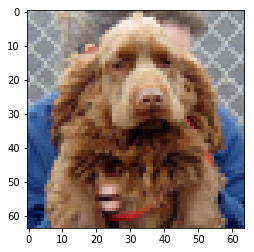

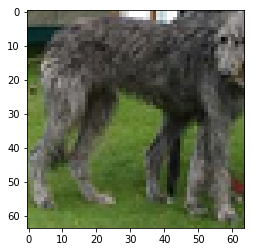

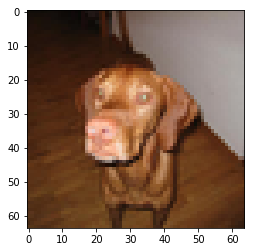

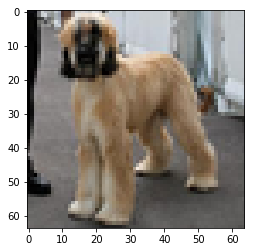

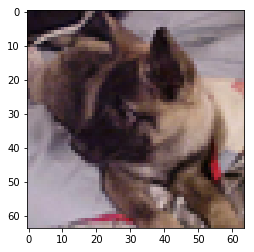

In [9]:
for i in range(5):
    plt.imshow(imgs[i]*0.5+0.5)
    plt.show()

## Initialize models and optimizers

In [10]:
netG = Generator(nz, ch=ch).to(device)
netD = Discriminator(ch=ch).to(device)

# EMA
ema_updater = update_average
netG_shadow = copy.deepcopy(netG)
ema_updater(netG_shadow, netG, beta=0)

# Loss
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MSELoss()
criterion = HardMarginBCEWithLogistsLoss(margin)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=0.00005)
# lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=0.00005)
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

## Training loop

In [11]:
loggor = open('log.txt','w')
start = time()
for epoch in range(epochs):
    if time() - start > 32000:
        print('Timeout!!!')
        break
#     if epoch in lr_steps:
#         for param_group in optimizerG.param_groups:
#             param_group['lr'] = param_group['lr']/5
#         for param_group in optimizerD.param_groups:
#             param_group['lr'] = param_group['lr']/5  
    if epoch in ema_steps:
        ema_beta = ema_beta + (1-ema_beta) * 0.9 
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels_real = torch.full((batch_size, 1), real_label, device=device)

#         output = netD(real_images)
#         errD_real = criterion(output, labels)
#         errD_real.backward()
#         D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, device=device)
        fake = netG(noise)
        labels_fake = torch.full((batch_size, 1), fake_label, device=device)
#         labels.fill_(fake_label)
        output_real, output_fake = netD(torch.cat([real_images, fake.detach()], 0)).split(batch_size, 0)
#         output_real = netD(real_images)
#         output_fake = netD(fake.detach())
        errD_real = criterion(output_real, labels_real)
        errD_fake = criterion(output_fake, labels_fake)
#         print(errD_real.item(), errD_fake.item())
        errD = errD_real + errD_fake
        errD.backward()
#         D_G_z1 = output.mean().item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels_fake.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels_fake)
        errG.backward()
#         D_G_z2 = output.mean().item()
        optimizerG.step()
        
        ema_updater(netG_shadow, netG, ema_beta)
#         with torch.no_grad():
#             netG_shadow(noise)
        if (ii+1) % (len(train_loader)//2) == 0:
            log = '[%d/%d][%d/%d] lr: %.2e Loss_D: %.4f Loss_G: %.4f EMA_beta: %.4f' \
                  % (epoch + 1, epochs, ii+1, len(train_loader), \
                     optimizerG.param_groups[0]['lr'], errD.item(), errG.item(), ema_beta)
            print(log)
            loggor.write(log+'\n')
            
    if False and epoch % 25==0:
        if not os.path.exists(f'../output_images_ep{epoch}'):
            os.mkdir(f'../output_images_ep{epoch}')
        im_batch_size = 100
        n_images=10000
        with torch.no_grad():
            for i_batch in range(0, n_images, im_batch_size):
                gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
                gen_images = netG(gen_z) * 0.5 + 0.5
                images = gen_images.to("cpu").clone().detach()
                images = images.numpy().transpose(0, 2, 3, 1)
                for i_image in range(gen_images.size(0)):
                    save_image(gen_images[i_image, :, :, :], os.path.join(f'../output_images_ep{epoch}', f'image_{i_batch+i_image:05d}.png'))
        import shutil
        shutil.make_archive(f'images_ep{epoch}', 'zip', f'../output_images_ep{epoch}')
#     lr_schedulerG.step(epoch)
#     lr_schedulerD.step(epoch)
#     show_generated_img()
    if False:
        show_generated_batch_imgs(100)
torch.save(netG_shadow.state_dict(), 'G.ckpt')
torch.save(netD.state_dict(), 'D.ckpt')
loggor.close()

[1/620][321/643] lr: 5.00e-04 Loss_D: 1.4303 Loss_G: 1.6521 EMA_beta: 0.9000
[1/620][642/643] lr: 5.00e-04 Loss_D: 1.0824 Loss_G: 1.8016 EMA_beta: 0.9000



[2/620][321/643] lr: 5.00e-04 Loss_D: 0.9957 Loss_G: 1.3069 EMA_beta: 0.9000
[2/620][642/643] lr: 5.00e-04 Loss_D: 0.4791 Loss_G: 3.1027 EMA_beta: 0.9000



[3/620][321/643] lr: 5.00e-04 Loss_D: 1.1686 Loss_G: 2.5541 EMA_beta: 0.9000
[3/620][642/643] lr: 5.00e-04 Loss_D: 0.6159 Loss_G: 2.9428 EMA_beta: 0.9000



[4/620][321/643] lr: 5.00e-04 Loss_D: 1.0632 Loss_G: 1.8927 EMA_beta: 0.9000
[4/620][642/643] lr: 5.00e-04 Loss_D: 1.2687 Loss_G: 1.7905 EMA_beta: 0.9000



[5/620][321/643] lr: 5.00e-04 Loss_D: 0.8358 Loss_G: 2.2127 EMA_beta: 0.9000
[5/620][642/643] lr: 5.00e-04 Loss_D: 0.8825 Loss_G: 2.4667 EMA_beta: 0.9000



[6/620][321/643] lr: 5.00e-04 Loss_D: 1.3248 Loss_G: 3.3221 EMA_beta: 0.9000
[6/620][642/643] lr: 5.00e-04 Loss_D: 1.0356 Loss_G: 1.9216 EMA_beta: 0.9000



[7/620][321/643] lr: 5.00e-04 Loss_D: 1.1090 Loss_G: 3.0331 EMA_beta: 0.9000
[7/620][642/643] lr: 5.00e-04 Loss_D: 1.3185 Loss_G: 2.2561 EMA_beta: 0.9000



[8/620][321/643] lr: 5.00e-04 Loss_D: 0.9845 Loss_G: 1.9146 EMA_beta: 0.9000
[8/620][642/643] lr: 5.00e-04 Loss_D: 1.0923 Loss_G: 2.3245 EMA_beta: 0.9000



[9/620][321/643] lr: 5.00e-04 Loss_D: 1.3672 Loss_G: 1.4012 EMA_beta: 0.9000
[9/620][642/643] lr: 5.00e-04 Loss_D: 0.9149 Loss_G: 2.6709 EMA_beta: 0.9000



[10/620][321/643] lr: 5.00e-04 Loss_D: 1.0089 Loss_G: 1.8511 EMA_beta: 0.9000
[10/620][642/643] lr: 5.00e-04 Loss_D: 1.0260 Loss_G: 2.6357 EMA_beta: 0.9000



[11/620][321/643] lr: 5.00e-04 Loss_D: 1.4959 Loss_G: 3.8353 EMA_beta: 0.9000
[11/620][642/643] lr: 5.00e-04 Loss_D: 1.1994 Loss_G: 2.5084 EMA_beta: 0.9000



## Let's visualise generated results 

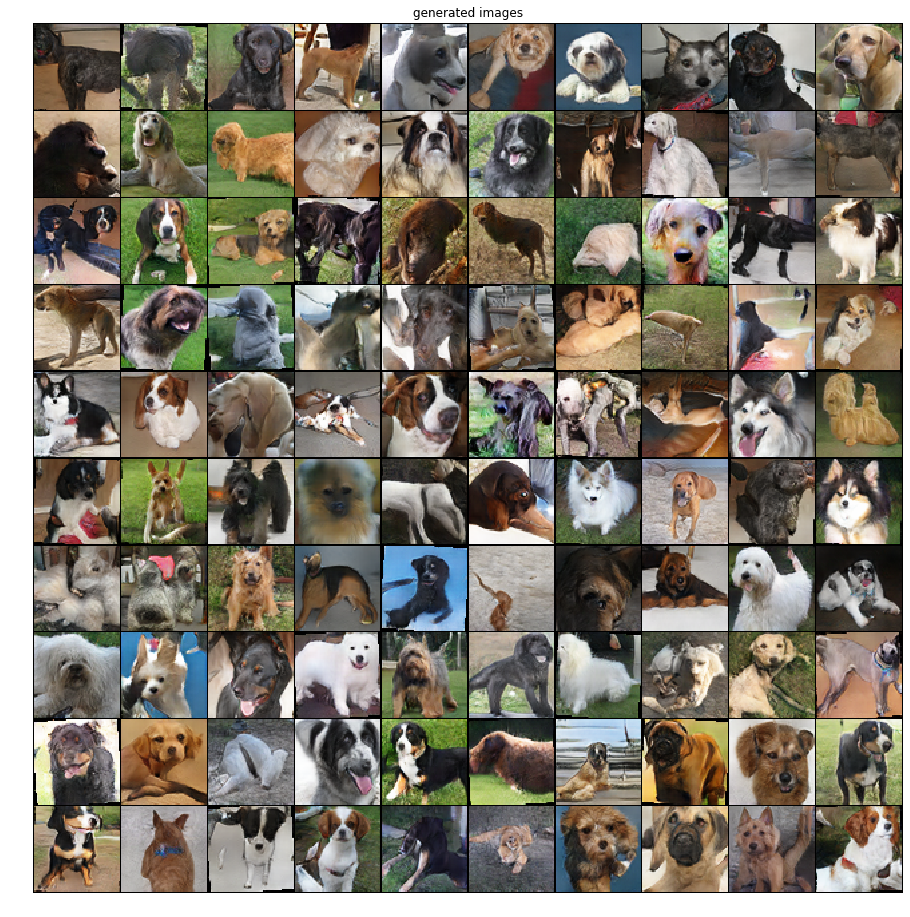

In [12]:
# for _ in range(25):
#     show_generated_img()
with torch.no_grad():
    show_generated_batch_imgs(100)

## Make predictions and submit

In [13]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 100
n_images=10000
with torch.no_grad():
    # Stablize BN
    if False:
        for i_batch in range(0, 4900, 100):
            gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
            gen_images = netG(gen_z)
    for i_batch in range(0, n_images, im_batch_size):
        gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
        gen_images = netG_shadow(gen_z) * 0.5 + 0.5
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'